In [1]:
# Make sure Runtime > Change runtime type is set to GPU

# Setup
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()
from fastbook import *
from fastai.text.all import *

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 719.8/719.8 kB 7.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.1/542.1 kB 10.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 9.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.9/64.9 kB 8.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 10.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 8.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 19.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21.3 MB 60.8 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests==2.31.0, but you have requests 2.32.3 which is incompatible.
Mounted at /content/gdrive


In [2]:
# Find the Tweet Sentiment dataset on the drive
import os
os.listdir("/content/gdrive/MyDrive/EAI6010")

['FaceMask.zip',
 'CatandDog.zip',
 'BrainTumor.zip',
 'Fruits.zip',
 'fruit.model',
 'tweet-sentiment-extraction.zip']

In [3]:
# Unzip the data set
!unzip "/content/gdrive/MyDrive/EAI6010/tweet-sentiment-extraction.zip"

print( "\n\n" )
os.listdir( )

Archive:  /content/gdrive/MyDrive/EAI6010/tweet-sentiment-extraction.zip
  inflating: sample_submission.csv   
  inflating: test.csv                
  inflating: train.csv               





['.config',
 'train.csv',
 'gdrive',
 'test.csv',
 'sample_submission.csv',
 'sample_data']

In [11]:
import pandas as pd
import numpy as np

In [12]:
# load the 'train.csv'
df = pd.read_csv('train.csv')
df

# We have the text ID, text, selected_text, and sentiment categories.

,textID,text,selected_text,sentiment
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative
2,088c60f138,my boss is bullying me...,bullying me,negative
3,9642c003ef,what interview! leave me alone,leave me alone,negative
4,358bd9e861,"Sons of ****, why couldn`t they put them on the releases we already bought","Sons of ****,",negative
...,...,...,...,...
27476,4eac33d1c0,wish we could come see u on Denver husband lost his job and can`t afford it,d lost,negative
27477,4f4c4fc327,"I`ve wondered about rake to. The client has made it clear .NET only, don`t force devs to learn a new lang #agile #ccnet",", don`t force",negative
27478,f67aae2310,Yay good for both of you. Enjoy the break - you probably need it after such hectic weekend Take care hun xxxx,Yay good for both of you.,positive
27479,ed167662a5,But it was worth it ****.,But it was worth it ****.,positive


In [14]:
df.isna().sum()

textID           0
text             1
selected_text    1
sentiment        0
dtype: int64

In [15]:
# Fill NaN values in 'selected_text' with empty strings and ensure all entries are strings
df['selected_text'] = df['selected_text'].fillna('').astype(str)

In [16]:
# Let's follow the convention of a folder per class with single files per record

# Extract categories and texts
category_subset = df['sentiment'].unique()

# Reset the root directory if we need to -- we check and delete so this code is repeatable
root_dir_name = "texts_by_category"
print(f"Setting up '{root_dir_name}'")
if os.path.exists(root_dir_name):
    shutil.rmtree(root_dir_name)
os.mkdir(root_dir_name)

# Initialize the counts for each of the subset
category_to_count = {category: 0 for category in category_subset}

# Create a file for each record and put it in a subfolder named for the category
count = 0
total_words = 0  # we need to set a sequence length for the language model, so we should capture the typical lengths of the documents

for index, row in df.iterrows():
    category = row['sentiment']
    document_text = row['selected_text']

    # Update the processed count and show the progress if we should
    count += 1
    if count % 10000 == 0:
        print(f"Creating file for record {int(count / 1000)}k")

    # Setup the directory if it doesn't exist
    dir_path = os.path.join(root_dir_name, category)
    if not os.path.exists(dir_path):
        os.mkdir(dir_path)

    # Save the document text to file
    category_to_count[category] += 1
    filename = f"{category}-{category_to_count[category]}.txt"
    file_path = os.path.join(dir_path, filename)

    with open(file_path, "w") as f:
        f.write(document_text)

    # Save the word length
    total_words += len(document_text.split(" "))

# Verify the directories
print(f"\nWorking directory:\n{os.listdir()}")
print(f"\nData directory:\n{os.listdir(root_dir_name)}")
for category in category_subset[:2]:  # just checking first two categories for brevity
    category_dir_path = os.path.join(root_dir_name, category)
    print(f"\n'{category_dir_path}'':\n{os.listdir(category_dir_path)}")

# Verify a document from the second category
category_dir_path = os.path.join(root_dir_name, category_subset[1])
sample_file_path = os.path.join(category_dir_path, f"{category_subset[1]}-1.txt")
with open(sample_file_path, 'r') as f:
    document_content = f.read()
    print(f"\n{category_subset[1]} document content:\n{document_content}")

# Calculate the average document length so we can intelligently set the sequence length
avg_document_words = round(total_words / count)
print(f"\nAverage number of words in a document = {avg_document_words}")


Setting up 'texts_by_category'
Creating file for record 10k
Creating file for record 20k

Working directory:
['.config', 'train.csv', 'gdrive', 'texts_by_category', 'test.csv', 'sample_submission.csv', 'sample_data']

Data directory:
['positive', 'negative', 'neutral']

'texts_by_category/neutral'':
['neutral-747.txt', 'neutral-10905.txt', 'neutral-6845.txt', 'neutral-3929.txt', 'neutral-2304.txt', 'neutral-4325.txt', 'neutral-10030.txt', 'neutral-5345.txt', 'neutral-10433.txt', 'neutral-2039.txt', 'neutral-2146.txt', 'neutral-9800.txt', 'neutral-6263.txt', 'neutral-10045.txt', 'neutral-9353.txt', 'neutral-8477.txt', 'neutral-6647.txt', 'neutral-2472.txt', 'neutral-5008.txt', 'neutral-1998.txt', 'neutral-3841.txt', 'neutral-4675.txt', 'neutral-7328.txt', 'neutral-8877.txt', 'neutral-7796.txt', 'neutral-7584.txt', 'neutral-9143.txt', 'neutral-6689.txt', 'neutral-5891.txt', 'neutral-2880.txt', 'neutral-8132.txt', 'neutral-7658.txt', 'neutral-6372.txt', 'neutral-3801.txt', 'neutral-3513.t

In [30]:
# Now that we have data in a format that is typical, let's get it ready to fine
# tune a language model

# First the data block to tell how normalize things -- there is caching
# happening in the data block -- if you change the directory content at all
# after this object is created, do a "Factory reset runtime" (Runtime menu) to
# fully reset the environment
language_model_block = DataBlock( # https://docs.fast.ai/data.block.html
  blocks = TextBlock.from_folder( root_dir_name, is_lm = True ), # read the data from folder and indicate the data is to be used for a language model
  get_items = get_text_files, # each item is a text file
  splitter = RandomSplitter( seed = 42 ) # randomly split the samples
)

# And now data loaders
language_model_loaders = language_model_block.dataloaders( root_dir_name, bs = 128, seq_len = 5) # 128 batch size & sequence length roughly 2/3 the average document length

# Show a batch to confirm
language_model_loaders.show_batch( max_n = 3 )

# The left is the input and the right is the target. You can see we are
# are using seq_len words to predict seq_len words that have been shifted
# forward by a single word.

/usr/local/lib/python3.10/dist-packages/spacy/util.py:1740: UserWarning: [W111] Jupyter notebook detected: if using `prefer_gpu()` or `require_gpu()`, include it in the same cell right before `spacy.load()` to ensure that the model is loaded on the correct device. More information: http://spacy.io/usage/v3#jupyter-notebook-gpu
  warnings.warn(Warnings.W111)


,text,text_
0,xxbos thanks xxbos xxmaj who,thanks xxbos xxmaj who thinks
1,when i try to add,i try to add a
2,_ xxunk ) xxbos headache,xxunk ) xxbos headache xxbos


In [31]:
# There is less to choose from here for pretrained models, let's use AWD_LSTM
# packaged with fast.ai

# Let's build a learner for the language model
learner = language_model_learner(
    language_model_loaders, # what data goes in
    AWD_LSTM, # what pretrained model to use -- here we have AWD_LSTM
    drop_mult = 0.3, #  randomly drop out this fraction of values
    metrics = [ accuracy, Perplexity( ) ] # perplexity is the cross entropy for language models - https://docs.fast.ai/metrics.html#Perplexity
).to_fp16( ) # optimize performance - https://docs.fast.ai/callback.fp16.html

LR suggestion = 4.37e-03


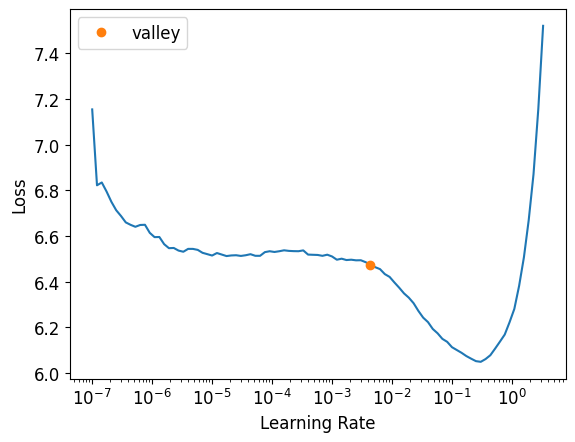

In [32]:
# What's a good learning rate for this model-problem?
lr_suggestion = learner.lr_find( )
print( f"LR suggestion = {lr_suggestion[ 0 ]:.2e}" )

In [33]:
# Let's do a single fine tune epoch with the suggested LR to see where we are --
# remember a single fine tuning epoch involves one epoch
learner.fit( 1, lr=4.37e-03 )

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,4.434210,4.353691,0.234578,77.764969,01:21


In [34]:
# We need to do a bit more fine tuning since our accuracy is roughly 23% --
for i in range( 3 ):
  print( f"\n\nfine tuning iteration #{i+1}" )
  learner.fit( 1, lr = 4.37e-03 )



fine tuning iteration #1


epoch,train_loss,valid_loss,accuracy,perplexity,time
0,4.226305,4.304405,0.236441,74.025169,01:15




fine tuning iteration #2


epoch,train_loss,valid_loss,accuracy,perplexity,time
0,4.077611,4.309067,0.236262,74.371048,01:16




fine tuning iteration #3


epoch,train_loss,valid_loss,accuracy,perplexity,time
0,3.972660,4.323012,0.234983,75.415466,01:16


In [37]:
# To finish up the langage model fine tuning we save the encoder to disk
language_model_path = os.path.join( "/content/gdrive/MyDrive/EAI6010/module_3_fine_tuned_language_model_lstm_01" )
with open( language_model_path, "wb" ) as f:
  learner.save_encoder( f ) # show the model in google drive

In [38]:
# To start on the classifier we need to create new data block and loaders

# Start with a new data block
vocabulary = language_model_loaders.vocab # don't create a new vocabulary, use the same that was created for the language model
classifier_block = DataBlock(
    blocks = ( TextBlock.from_folder( root_dir_name, vocab=vocabulary ), CategoryBlock ), # x & y
    get_y = parent_label, # y values are the names of the folder that contain the documents
    get_items = get_text_files,
    splitter = RandomSplitter( seed = 42 ) # randomly split the samples
)

# And the data loaders
classifier_loaders = classifier_block.dataloaders( root_dir_name, bs = 128, seq_len = 5 ) # 128 batch size & sequence length roughly 2/3 of the average document length

# Show a batch to confirm
classifier_loaders.show_batch( max_n = 3 )

# This time the x is the text and the y is the category


/usr/local/lib/python3.10/dist-packages/spacy/util.py:1740: UserWarning: [W111] Jupyter notebook detected: if using `prefer_gpu()` or `require_gpu()`, include it in the same cell right before `spacy.load()` to ensure that the model is loaded on the correct device. More information: http://spacy.io/usage/v3#jupyter-notebook-gpu
  warnings.warn(Warnings.W111)


,text,category
0,xxbos xxup ugg xxup want xxup to xxup go xxup to xxup xxunk xxup house xxup but i xxup ca nt xxup xxunk xxup be xxup bored xxup this xxup weekend xxrep 3 ! xxrep 3 u xxup xxunk xxup wanna xxup spend xxup da xxup nite xxup and xxup go xxup see xxup up xxup and xxup go xxup shopping,neutral
1,xxbos ( ) 1 - xxunk = awesome ! 2 - goodbyes suck 3 - shut up plz . 4 - toy xxmaj story 3 ! ! 5 - jb 3d xxup movie 2moro ! 6 - i`m tired . 7 - a xxrep 3 a nd xxmaj i`m out .,neutral
2,xxbos xxup omg i xxup finished xxup my xxup history xxup xxunk xxup book xxrep 4 ! xxup just xxup need 2 xxup make xxup it xxup pretty xxup and xxup print xxup it xxup off xxup and xxup i m xxup done xxrep 3 ! xxup whoo xxrep 3 !,neutral


In [39]:
# Now its time to create the classification model

# We start by creating a new learner starting with the same model as the
# language model
learner = text_classifier_learner(
    classifier_loaders, # what data goes in -- this time its the classifier_loaders
    AWD_LSTM, # what pretrained model to use -- here we have AWD_LSTM
    drop_mult = 0.3, #  randomly drop out this fraction of values
    metrics = accuracy # classification accuracy is what we'll use to evaluate performance
).to_fp16( ) # optimize performance - https://docs.fast.ai/callback.fp16.html

# Now, let's load the language model that was fined tuned for this set and
# overwrite the encoding portion of the new learner
with open( language_model_path, "rb" ) as f:
  learner = learner.load_encoder( f )


In [40]:
# Let's find our feet by doing a single fine tuning epoch to see where we are
learner.fine_tune( 1 )

epoch,train_loss,valid_loss,accuracy,time
0,0.864561,0.663445,0.725437,00:30


epoch,train_loss,valid_loss,accuracy,time
0,0.724857,0.572184,0.781841,00:36


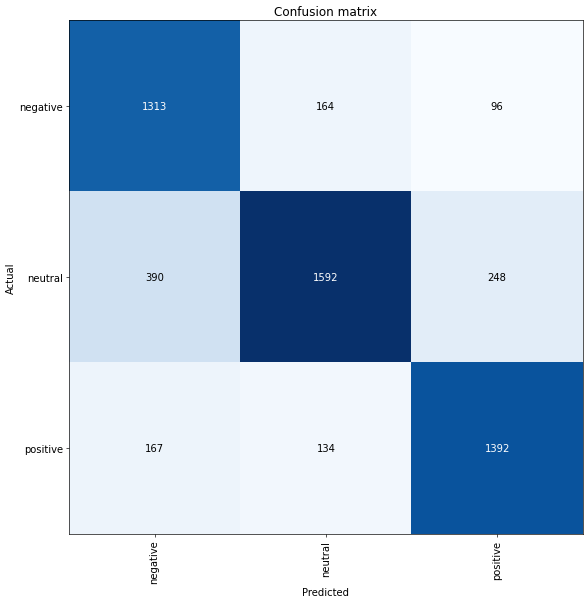

In [42]:
#  What does the confusion matrix look like after a single epoch?
interpretation = ClassificationInterpretation.from_learner( learner )
interpretation.plot_confusion_matrix( figsize = ( 10, 10 ), dpi = 60 )

# Pretty good result, try to tune a bit more

LR suggestion: 2.75e-06


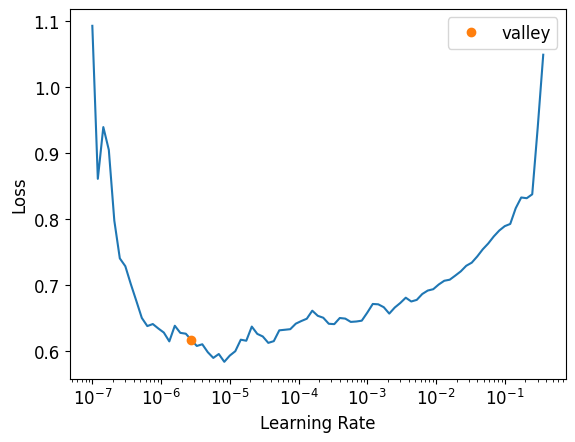

In [43]:
# We'll get a good learning rate
lr_suggestion = learner.lr_find( )
print( f"LR suggestion: {lr_suggestion[ 0 ]:.2e}" )

In [44]:
# Gradual unfreezing -- p.349

# Lets do a couple of fine tuning epochs
for i in range( 1 ):
  print( f"\n\nfine tuning iteration #{i+1}" )
  learner.fine_tune( 1, base_lr = 2.75e-06 )

 # We got a lower result here compared to the epoch above



fine tuning iteration #1


epoch,train_loss,valid_loss,accuracy,time
0,0.705301,0.592512,0.764556,00:34


epoch,train_loss,valid_loss,accuracy,time
0,0.686788,0.595776,0.761463,00:32


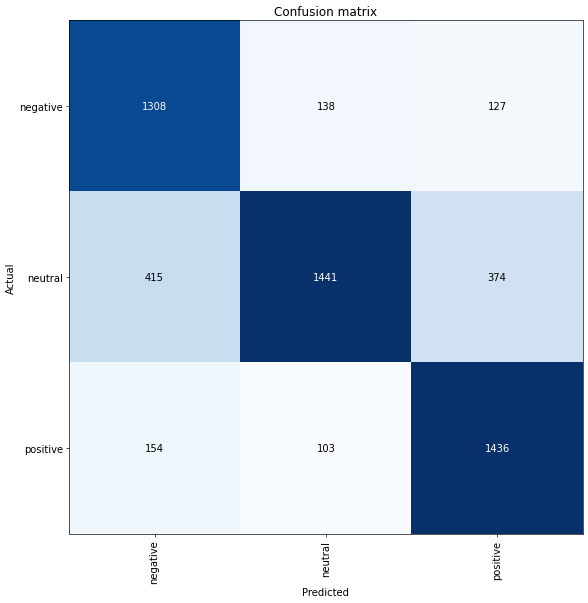

In [45]:
# And finally the confusion matrix
interpretation = ClassificationInterpretation.from_learner( learner )
interpretation.plot_confusion_matrix( figsize = ( 10, 10 ), dpi = 60 )

In [47]:
# Let's end by getting a test accuracy for comparison
pred_scores, targets = learner.get_preds( ) # uses default ds_idx=1 that is validation
preds = torch.argmax( pred_scores, dim=1 )
correct_count = 0
for i in range( len( preds ) ):
  if preds[ i ] == targets[ i ]: # a way to get the test documents that were incorrect
    correct_count = correct_count + 1
accuracy = round( 100 * ( correct_count / len( preds ) ) )
print( f'test accuracy: {accuracy}%' )

test accuracy: 76%


In [48]:
# Let's finish up by saving the classifier to disk
classifier_path = "/content/gdrive/MyDrive/EAI6010/module_3_tweet_sentiment_classifier"
learner.export( classifier_path ) # show in google drive

In [49]:
# Let's load the model and make a prediction
learner = []
learner = load_learner( classifier_path )
content = "We got such a fun experiment this afternoon."
prediction, prediction_possibility, prediction_possibilities = learner.predict( content )
print( f"prediction = {prediction}\n\n" )

prediction = positive


